In [1]:
from cosmic.sample.initialbinarytable import InitialBinaryTable
from cosmic.evolve import Evolve
from cosmic.utils import convert_kstar_evol_type
from cosmic.plotting import evolve_and_plot

import numpy as np
import matplotlib.pyplot as plt
import tqdm

In [2]:
# Helper functions and variables for unit conversions

def aui_to_porb(aui, m_tot):
    # aui: a list of values, initial separation in AU
    # m_tot: a list of values, total mass in M_sun
    # result: a list of values, orbital period in given condition in days
    res = []
    for i in range(len(aui)):
        res.append((1/m_tot[i]**0.5) * (aui[i]**1.5) * 365)
    return res

# Used to convert separation in R_sun into AU
unit_factor = 1 / 215.032

# Helper function: given an array of data and an array of target,
# return an array of index that is nearest to the target value.
import math 
def findNearestList(data, targetList):
    res = []
    for num in targetList:
        res.append(findNearest(data, num))
    return res

def findNearest(data, target):
    n = len(data)
    res = -1
    minDiff = 10**5
    for i in range(n):
        if data[i] == 10**(-5):
            continue
        if abs(target - data[i]) <= minDiff:
            res = i
            minDiff = abs(target - data[i])
    return res

In [3]:
# Default BSEDict with modified qcrit_array
# force stable mass transfer
BSEDict = {'xi': 1.0, 'bhflag': 1, 'neta': 0.5, 'windflag': 3, 'wdflag': 1, 'alpha1': 1.0, 'pts1': 0.001, 
           'pts3': 0.02, 'pts2': 0.01, 'epsnov': 0.001, 'hewind': 0.5, 'ck': 1000, 'bwind': 0.0, 'lambdaf': 0.0, 
           'mxns': 3.0, 'beta': -1.0, 'tflag': 1, 'acc2': 1.5, 'grflag' : 1, 'remnantflag': 4, 'ceflag': 0, 
           'eddfac': 1.0, 'ifflag': 0, 'bconst': 3000, 'sigma': 265.0, 'gamma': -2.0, 'pisn': 45.0, 
           'natal_kick_array' : [[-100.0,-100.0,-100.0,-100.0,0.0], [-100.0,-100.0,-100.0,-100.0,0.0]], 
           'bhsigmafrac' : 1.0, 'polar_kick_angle' : 90, 
           'qcrit_array' : [20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0], 
           'cekickflag' : 2, 'cehestarflag' : 0, 'cemergeflag' : 0, 'ecsn' : 2.25, 'ecsn_mlow' : 1.6, 
           'aic' : 1, 'ussn' : 0, 'sigmadiv' :-20.0, 'qcflag' : 1, 'eddlimflag' : 0, 
           'fprimc_array' : [2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0], 
           'bhspinflag' : 0, 'bhspinmag' : 0.0, 'rejuv_fac' : 1.0, 'rejuvflag' : 0, 'htpmb' : 1, 'ST_cr' : 1, 
           'ST_tide' : 1, 'bdecayfac' : 1, 'rembar_massloss' : 0.5, 'kickflag' : 0, 'zsun' : 0.014, 'bhms_coll_flag' : 0, 
           'don_lim' : -1, 'acc_lim' : -1, 'rtmsflag' : 0, 'wd_mass_lim': 1}

In [4]:
NUM_SEP = 400

MASS_1 = 7
MASS_2 = 1
MASS_TOT = 8

ECC = 0

SEP_START = 2
SEP_END = 8

SOLAR_MET = 0.02

TPHYS_LIM = 20000

## results for `acc_lim = 0`

In [5]:
BSEDict['acc_lim'] = 0

In [6]:
# List of initial conditions for simulation later

m1_list = [MASS_1 for i in range(NUM_SEP)]
m2_list = [MASS_2 for i in range(NUM_SEP)]
mtot_list = [MASS_TOT for i in range(NUM_SEP)]
ai_list = np.linspace(SEP_START, SEP_END, NUM_SEP)
porb_i_list = aui_to_porb(ai_list, mtot_list)

ecc_list = [ECC for i in range(NUM_SEP)]
tphysf_list = [TPHYS_LIM for i in range(NUM_SEP)]
kstar1_list = [1 for i in range(NUM_SEP)]
kstar2_list = [1 for i in range(NUM_SEP)]
metallicity_list = [SOLAR_MET for i in range(NUM_SEP)] # solar metallicity

In [7]:
binary_set = InitialBinaryTable.InitialBinaries(m1=m1_list, m2=m2_list, 
                                                porb=porb_i_list, ecc=ecc_list, 
                                                tphysf=tphysf_list, kstar1=kstar1_list, kstar2=kstar2_list, 
                                                metallicity=metallicity_list)

In [8]:
data1 = np.zeros(NUM_SEP)
data4 = np.zeros(NUM_SEP)

bpp, bcm, initC, kick_info = Evolve.evolve(initialbinarytable=binary_set, BSEDict=BSEDict)
bpp['sep in AU'] = bpp['sep'] * unit_factor

for i in tqdm.tqdm(range(NUM_SEP)):
    single_bpp = bpp.loc[i].copy()
    # print(single_bpp[['tphys', 'mass_1', 'mass_2', 'kstar_1', 'kstar_2', 'sep in AU', 'evol_type']])
    
    # cond1 = (single_bpp['evol_type'] == 4)
    cond2 = (single_bpp['kstar_1'] <= 12) 
    cond3 = (single_bpp['kstar_1'] >= 10) # Select kstar_1 to be WD
    cond4 = (single_bpp['kstar_2'] <= 1)
    cond5 = (single_bpp['kstar_2'] >= 0) # Select kstar_2 to be MS
    # cond2 = (single_bpp['evol_type']==8)
    
    specific_rows = single_bpp[(cond2) & (cond3) & (cond4) & (cond5)]
    if (len(specific_rows) > 0):
        row = specific_rows.iloc[0]
        data1[i] = row['sep in AU']
        data4[i] = row['mass_2']
    else: data1[i] = -1

100%|████████████████████████████████████████| 400/400 [00:00<00:00, 872.69it/s]


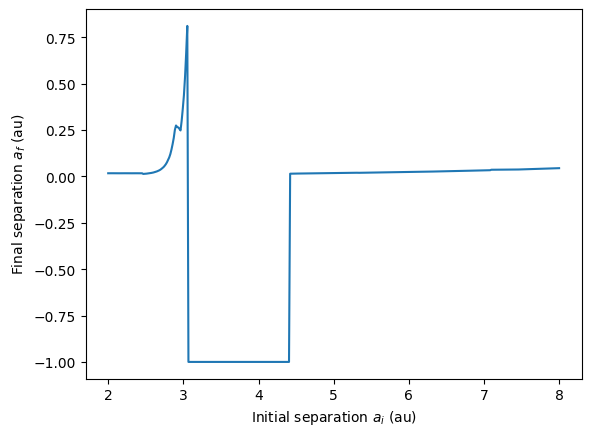

In [9]:
# Create the plot
plt.plot(ai_list, data1)

# Add titles and labels
plt.xlabel(r'Initial separation $a_i$ (au)')
plt.ylabel(r'Final separation $a_f$ (au)')

# Show the plot
plt.show()

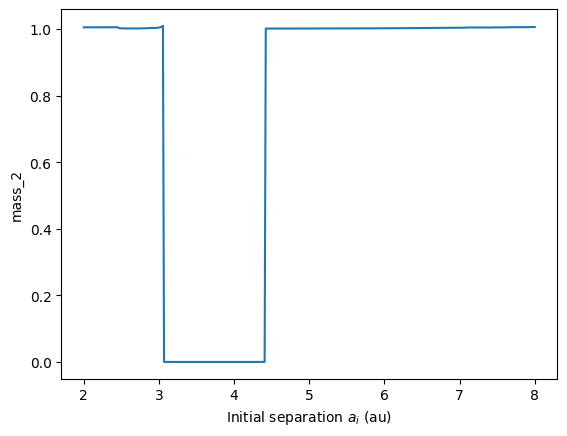

In [10]:
# Create the plot
plt.plot(ai_list, data4)

# Add titles and labels
plt.xlabel(r'Initial separation $a_i$ (au)')
plt.ylabel(r'mass_2')

# Show the plot
plt.show()

## results for `acc_lim = 0.5`

In [11]:
BSEDict['acc_lim'] = 0.5

In [12]:
NUM_SEP = 400

MASS_1 = 7
MASS_2 = 1
MASS_TOT = 8

ECC = 0

SEP_START = 2
SEP_END = 8

SOLAR_MET = 0.02

TPHYS_LIM = 20000

In [13]:
# List of initial conditions for simulation later

m1_list = [MASS_1 for i in range(NUM_SEP)]
m2_list = [MASS_2 for i in range(NUM_SEP)]
mtot_list = [MASS_TOT for i in range(NUM_SEP)]
ai_list = np.linspace(SEP_START, SEP_END, NUM_SEP)
porb_i_list = aui_to_porb(ai_list, mtot_list)

ecc_list = [ECC for i in range(NUM_SEP)]
tphysf_list = [TPHYS_LIM for i in range(NUM_SEP)]
kstar1_list = [1 for i in range(NUM_SEP)]
kstar2_list = [1 for i in range(NUM_SEP)]
metallicity_list = [SOLAR_MET for i in range(NUM_SEP)] # solar metallicity

In [14]:
binary_set = InitialBinaryTable.InitialBinaries(m1=m1_list, m2=m2_list, 
                                                porb=porb_i_list, ecc=ecc_list, 
                                                tphysf=tphysf_list, kstar1=kstar1_list, kstar2=kstar2_list, 
                                                metallicity=metallicity_list)

In [15]:
data2 = np.zeros(NUM_SEP)
data5 = np.zeros(NUM_SEP)

bpp, bcm, initC, kick_info = Evolve.evolve(initialbinarytable=binary_set, BSEDict=BSEDict)
bpp['sep in AU'] = bpp['sep'] * unit_factor

for i in tqdm.tqdm(range(NUM_SEP)):
    single_bpp = bpp.loc[i].copy()
    # print(single_bpp[['tphys', 'mass_1', 'mass_2', 'kstar_1', 'kstar_2', 'sep in AU', 'evol_type']])
    
    # cond1 = (single_bpp['evol_type'] == 4)
    cond2 = (single_bpp['kstar_1'] <= 12) 
    cond3 = (single_bpp['kstar_1'] >= 10) # Select kstar_1 to be WD
    cond4 = (single_bpp['kstar_2'] <= 1)
    cond5 = (single_bpp['kstar_2'] >= 0) # Select kstar_2 to be MS
    # cond2 = (single_bpp['evol_type']==8)
    
    specific_rows = single_bpp[(cond2) & (cond3) & (cond4) & (cond5)]
    if (len(specific_rows) > 0):
        row = specific_rows.iloc[0]
        data2[i] = row['sep in AU']
        data5[i] = row['mass_2']
    else: data2[i] = -1

100%|████████████████████████████████████████| 400/400 [00:00<00:00, 828.79it/s]


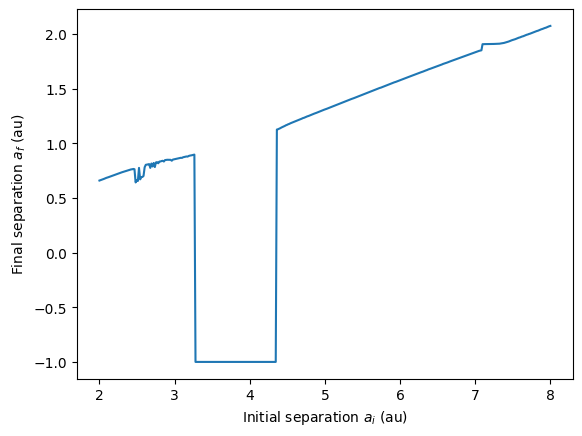

In [16]:
# Create the plot
plt.plot(ai_list, data2)
# plt.axhline(0.15)

# Add titles and labels
plt.xlabel(r'Initial separation $a_i$ (au)')
plt.ylabel(r'Final separation $a_f$ (au)')

# Show the plot
plt.show()

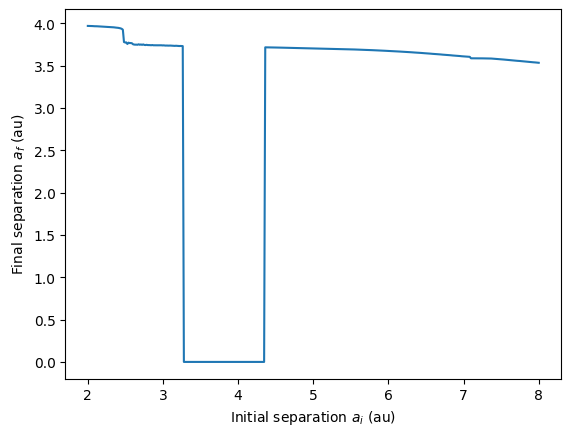

In [17]:
# Create the plot
plt.plot(ai_list, data5)

# Add titles and labels
plt.xlabel(r'Initial separation $a_i$ (au)')
plt.ylabel(r'Final separation $a_f$ (au)')

# Show the plot
plt.show()

## results for `acc_lim = 1.0`

In [18]:
BSEDict['acc_lim'] = 1.0

In [19]:
NUM_SEP = 400

MASS_1 = 7
MASS_2 = 1
MASS_TOT = 8

ECC = 0

SEP_START = 2
SEP_END = 8

SOLAR_MET = 0.02

TPHYS_LIM = 20000

In [20]:
# List of initial conditions for simulation later

m1_list = [MASS_1 for i in range(NUM_SEP)]
m2_list = [MASS_2 for i in range(NUM_SEP)]
mtot_list = [MASS_TOT for i in range(NUM_SEP)]
ai_list = np.linspace(SEP_START, SEP_END, NUM_SEP)
porb_i_list = aui_to_porb(ai_list, mtot_list)

ecc_list = [ECC for i in range(NUM_SEP)]
tphysf_list = [TPHYS_LIM for i in range(NUM_SEP)]
kstar1_list = [1 for i in range(NUM_SEP)]
kstar2_list = [1 for i in range(NUM_SEP)]
metallicity_list = [SOLAR_MET for i in range(NUM_SEP)] # solar metallicity

In [21]:
binary_set = InitialBinaryTable.InitialBinaries(m1=m1_list, m2=m2_list, 
                                                porb=porb_i_list, ecc=ecc_list, 
                                                tphysf=tphysf_list, kstar1=kstar1_list, kstar2=kstar2_list, 
                                                metallicity=metallicity_list)

In [22]:
data3 = np.zeros(NUM_SEP)
data6 = np.zeros(NUM_SEP)

bpp, bcm, initC, kick_info = Evolve.evolve(initialbinarytable=binary_set, BSEDict=BSEDict)
bpp['sep in AU'] = bpp['sep'] * unit_factor

for i in tqdm.tqdm(range(NUM_SEP)):
    single_bpp = bpp.loc[i].copy()
    # print(single_bpp[['tphys', 'mass_1', 'mass_2', 'kstar_1', 'kstar_2', 'sep in AU', 'evol_type']])
    
    # cond1 = (single_bpp['evol_type'] == 4)
    cond2 = (single_bpp['kstar_1'] <= 12) 
    cond3 = (single_bpp['kstar_1'] >= 10) # Select kstar_1 to be WD
    cond4 = (single_bpp['kstar_2'] <= 1)
    cond5 = (single_bpp['kstar_2'] >= 0) # Select kstar_2 to be MS
    # cond2 = (single_bpp['evol_type']==8)
    
    specific_rows = single_bpp[(cond2) & (cond3) & (cond4) & (cond5)]
    if (len(specific_rows) > 0):
        row = specific_rows.iloc[0]
        data3[i] = row['sep in AU']
        data6[i] = row['mass_2']
    else: data3[i] = -1

100%|████████████████████████████████████████| 400/400 [00:00<00:00, 710.76it/s]


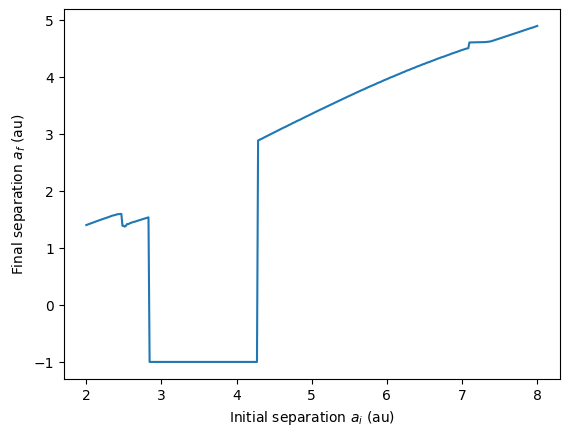

In [23]:
# Create the plot
plt.plot(ai_list, data3)

# Add titles and labels
plt.xlabel(r'Initial separation $a_i$ (au)')
plt.ylabel(r'Final separation $a_f$ (au)')

# Show the plot
plt.show()

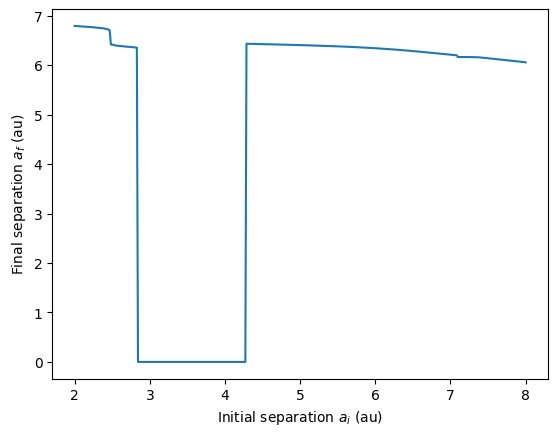

In [24]:
# Create the plot
plt.plot(ai_list, data6)

# Add titles and labels
plt.xlabel(r'Initial separation $a_i$ (au)')
plt.ylabel(r'Final separation $a_f$ (au)')

# Show the plot
plt.show()

In [25]:
new1 = []
list1 = []
new4 = []
for i in range(len(data1)):
    if data1[i] != -1:
        list1.append(ai_list[i])
        new1.append(data1[i])
        new4.append(data4[i])
data1=new1
data4=new4

new2 = []
list2 = []
new5 = []
for i in range(len(data2)):
    if data2[i] != -1:
        list2.append(ai_list[i])
        new2.append(data2[i])
        new5.append(data5[i])
data2=new2
data5=new5

new3 = []
list3 = []
new6 = []
for i in range(len(data3)):
    if data3[i] != -1:
        list3.append(ai_list[i])
        new3.append(data3[i])
        new6.append(data6[i])
data3=new3
data6=new6

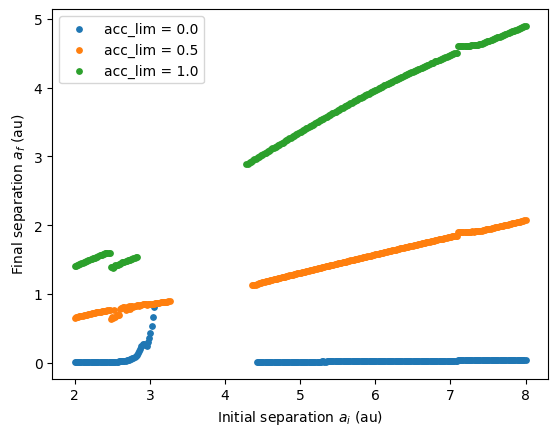

In [26]:
# Create the plot
plt.scatter(list1, new1, label = 'acc_lim = 0.0', s=15)
plt.scatter(list2, data2, label = 'acc_lim = 0.5', s=15)
plt.scatter(list3, data3, label = 'acc_lim = 1.0', s=15)

# Add titles and labels
plt.xlabel(r'Initial separation $a_i$ (au)')
plt.ylabel(r'Final separation $a_f$ (au)')
plt.legend()

# Show the plot
plt.show()

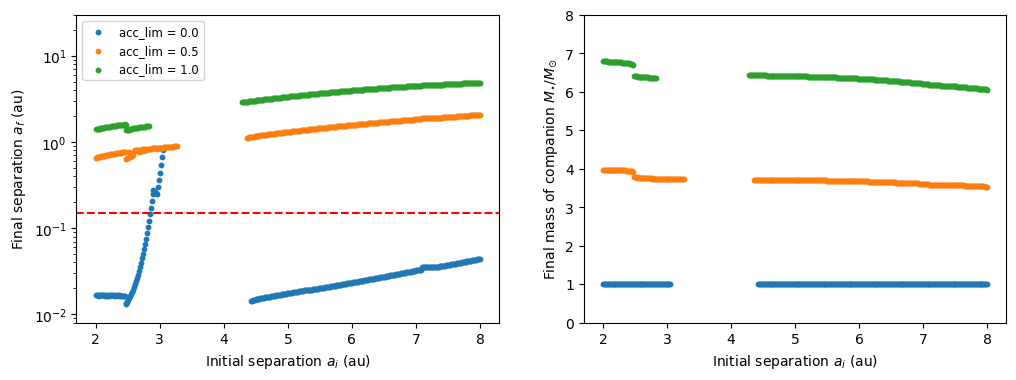

In [46]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].scatter(list1, data1, label = 'acc_lim = 0.0', s=10)
axs[0].scatter(list2, data2, label = 'acc_lim = 0.5', s=10)
axs[0].scatter(list3, data3, label = 'acc_lim = 1.0', s=10)

axs[1].scatter(list1, new4, label = 'acc_lim = 0.0', s=10)
axs[1].scatter(list2, new5, label = 'acc_lim = 0.5', s=10)
axs[1].scatter(list3, new6, label = 'acc_lim = 1.0', s=10)

# Add titles and labels
axs[0].set_xlabel(r'Initial separation $a_i$ (au)')
axs[0].set_ylabel(r'Final separation $a_f$ (au)')
axs[0].legend(loc='upper left', fontsize='small')
axs[0].axhline(y=0.15, color='red', linestyle='--')
axs[0].set_yscale('log')
axs[0].set_ylim(0.008, 30)

axs[1].set_xlabel(r'Initial separation $a_i$ (au)')
axs[1].set_ylabel(r'Final mass of companion $M_{\star} / M_{\odot}$')
# axs[1].legend()
axs[1].set_ylim(0, 8)


# Show the plot
plt.savefig('stable7+1', dpi=300)
plt.show()

In [ ]:
print(list1)
print(data1)
print(new4)